In [1]:
import zipfile
import os

# Specify the path to your zip file
zip_path = "faces.zip"
extract_to = "faces"

# Ensure the extraction directory exists
os.makedirs(extract_to, exist_ok=True)

# Unzip the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print(f"Extracted to: {extract_to}")


Extracted to: faces


In [ ]:
# Uncomment this if you are using Colab
# ## Mount google drive: If your dataset is saved on google drive
# from google.colab import drive
# drive.mount('/content/drive')

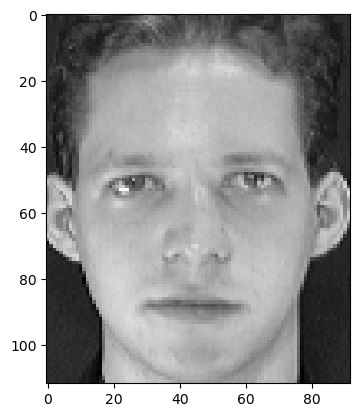

h:  112  width:  92
Training data shape: (10304, 280)
Testing data shape: (10304, 120)


In [7]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt


# Step 1: Load the images

# b) Load the first image
imFirst = np.array(Image.open('faces/s1/1.pgm'))
imFirst = imFirst.astype('float32')
imFirst /= 255.0
imFirst = np.clip(imFirst, 0.0, 1.0)
plt.imshow(imFirst, cmap='gray')
plt.show()

# c) Load the training images (40 persons X 7 images)
nTrainImages = 40 * 7  # number of training images
height, width = imFirst.shape  # The images have the same size. Use the first one to calculate the number of pixels
print('h: ',height,' width: ',width)
# imagesTrain = np.zeros((height * width, nTrainImages))  # Matrix with the training images as rows # original
# TODO: write a piece of code to load all training data into imagesTrain
# NOTE: You can use another more 'python' way to replace this c++ style data assignment: append every image in a list, and use np.stack to stack them into a batch, then flatten only width and height dimension

imagesTrain = []
for person in range(1, 41):
    for img_idx in range(1, 8):  # Training images: 1.pgm to 7.pgm
        img_path = f"faces/s{person}/{img_idx}.pgm"
        img = np.array(Image.open(img_path)).astype('float32') / 255.0
        imagesTrain.append(img.flatten())  # Flatten the image and append to the list
 

# d) read testing images.
nTestImages = 40 * 3  # testing images
imagesTest = np.zeros((height * width, nTestImages))
# %%%TODO: write a piece of code to load all test data into imagesTest

imagesTest = []
for person in range(1, 41):
    for img_idx in range(8, 11):  # Training images: 1.pgm to 7.pgm
        img_path = f"faces/s{person}/{img_idx}.pgm"
        img = np.array(Image.open(img_path)).astype('float32') / 255.0
        imagesTest.append(img.flatten())  # Flatten the image and append to the list

imagesTest = np.stack(imagesTest, axis=0).T  # Each image is a column in the matrix

imagesTrain = np.array(imagesTrain).T
imagesTest = np.array(imagesTest)
# Print summary
print(f"Training data shape: {imagesTrain.shape}")  # (height*width, 280)
print(f"Testing data shape: {imagesTest.shape}")    # (height*width, 120)       


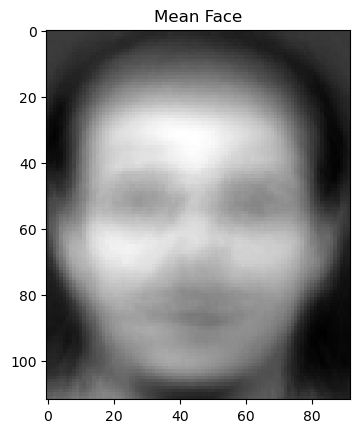

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Step 2: PCA
# a) find the mean image
mean_face = np.mean(imagesTrain, axis=1)
# TODO: visualize mean_face
plt.imshow(mean_face.reshape((height, width)), cmap='gray')
plt.title("Mean Face")
plt.show()

# b) mean-shifted input images
shifted_images = imagesTrain - mean_face[:, np.newaxis]

# This is a pre-step to optimize calculation. (see your lecture notes)
# TODO: normally we should find the covariance of shifted_images but it will be a 10304*10304 matrix!
# to be optimized and avoid "out of memory" error, we use a trick!
# Compute Y'*Y 


In [11]:

YY = 1/shifted_images.shape[0] * np.dot(shifted_images.T, shifted_images)
print(YY.shape)
# c) Compute eigenvectors and eigenvalues
evalues, small_evectors = np.linalg.eig(YY)
# Map back to the original space
evectors = np.dot(shifted_images, small_evectors)

(280, 280)


In [12]:


# d) Sort eigenvectors based on their corresponding eigenvalues
# TODO: put the results in "evectors" variable
sorted_indices = np.argsort(evalues)[::-1]
evalues = evalues[sorted_indices]
evectors = evectors[:, sorted_indices]

# e) only retain the top 'num_eigenfaces' eigenvectors (i.e. the principal components)
num_eigenfaces = 30
# TODO: put the results in "evectors" variable
evectors = evectors[:, :num_eigenfaces]

# Normalize the eigenvectors so || evector_i|| = 1
for i in range(num_eigenfaces):
    evectors[:, i] /= np.linalg.norm(evectors[:, i])

# f) project the images into the subspace to generate the feature vectors
# TODO: put the results in "features" variable
features = np.dot(evectors.T, shifted_images)

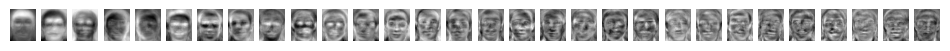

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Step 3: Analysis of eigen faces
# a) display the eigenvectors
fig, axes = plt.subplots(1, num_eigenfaces, figsize=(12, 4))
for n in range(num_eigenfaces):
    evector = evectors[:, n].reshape(height, width)
    axes[n].imshow(evector, cmap='gray')
    axes[n].axis('off')
plt.show()

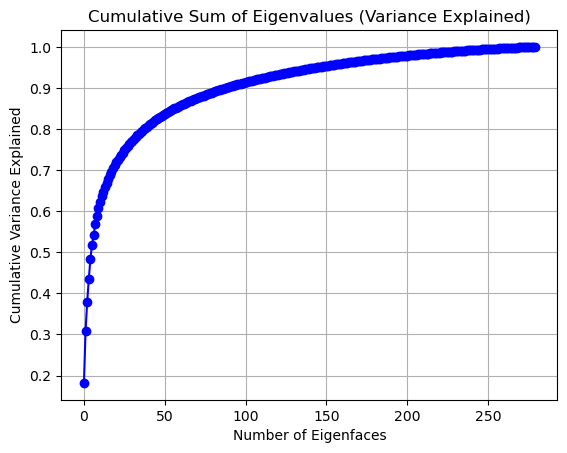

In [14]:
# b) display the cumulative eigenvalues
# TODO: hint: "cumsum" function for accumulation
cumulative_eigenvalues = np.cumsum(evalues)  # Calculate the cumulative sum of eigenvalues

# Plot cumulative eigenvalues
plt.plot(cumulative_eigenvalues / cumulative_eigenvalues[-1], marker='o', color='b')
plt.title('Cumulative Sum of Eigenvalues (Variance Explained)')
plt.xlabel('Number of Eigenfaces')
plt.ylabel('Cumulative Variance Explained')
plt.grid(True)
plt.show()

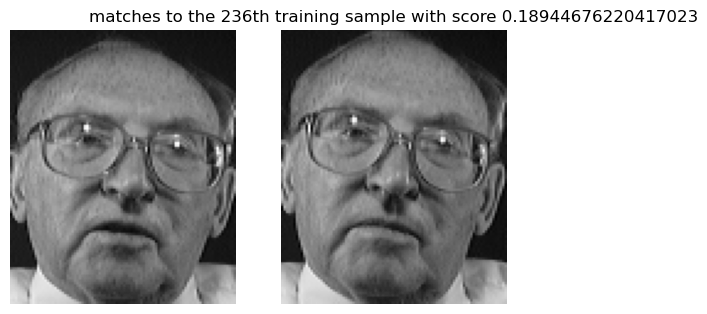

In [15]:
# Step 4: Identify a person
testIm = 100  # chose a person index
input_image = np.expand_dims(imagesTest[:, testIm],-1) 
# Tips: a shortcut way in python is input_image = imagesTest[:, testIm][..., None]

shifted_input_image = input_image - mean_face[:, np.newaxis]
shifted_imagesTrain = imagesTrain - mean_face[:, np.newaxis]

# calculate the similarity of the input to each training image
# TODO: put the result in "similarity_score" variable
# Project the test image into the PCA subspace to obtain feature vector
input_features = np.dot(evectors.T, shifted_input_image)

# Compute the similarity scores using Euclidean distance
distances = np.linalg.norm(features - input_features, axis=0)  # Compute L2 distance

# Compute similarity score (inverse Euclidean distance)
similarity_score = 1 / (1 + distances)  # Ensuring values stay in [0,1]

# find the image with the highest similarity
match_ix = np.argmax(similarity_score)

# display the result
fig, ax = plt.subplots(1, 2)
ax[0].imshow(input_image.reshape(height, width), cmap='gray')
ax[0].axis('off')
ax[1].imshow(imagesTrain[:, match_ix].reshape(height, width), cmap='gray')
ax[1].axis('off')
ax[1].set_title(f"matches to the {match_ix}th training sample with score {similarity_score[match_ix]}")
plt.show()

C:\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


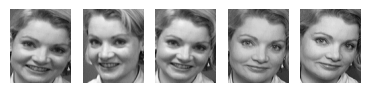

In [17]:
# Step 5: Cluster the persons
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
# a) Cluster the original images
# TODO: put the results in "clusters" variable. "clusters" indicates cluster number for each sample. 
#       please refer to KMeans in popular machine learning library: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
# Number of clusters (assuming one per person)
num_clusters = 40
# Apply K-Means clustering to the original high-dimensional images
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
clusters = kmeans.fit_predict(imagesTrain.T)  # Transpose so that samples are rows

# Show the the images that were assigned to cluster 1
img_index = np.where(clusters == 0)[0]

for i in range(min(len(img_index), 7)):
    plt.figure(111)
    plt.subplot(1, 7, i+1)
    img = np.reshape(imagesTrain[:, img_index[i]], (height, width))
    plt.imshow(img, cmap='gray')
    plt.axis('off')

C:\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


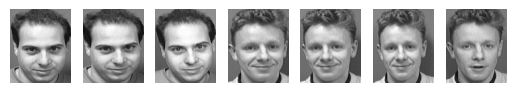

In [18]:
# b) Now cluster on the reduced space
# TODO: put the results in "clusters_pca" variable.

# Apply K-Means clustering in PCA subspace
kmeans_pca = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
clusters_pca = kmeans_pca.fit_predict(features.T)  # Features are already in PCA space

# Show the the images that were assigned to cluster 1
img_index = np.where(clusters_pca == 0)[0]
for i in range(min(len(img_index), 7)):
    plt.figure(111)
    plt.subplot(1, 7, i+1)
    img = np.reshape(imagesTrain[:, img_index[i]], (height, width))
    plt.imshow(img, cmap='gray')
    plt.axis('off')

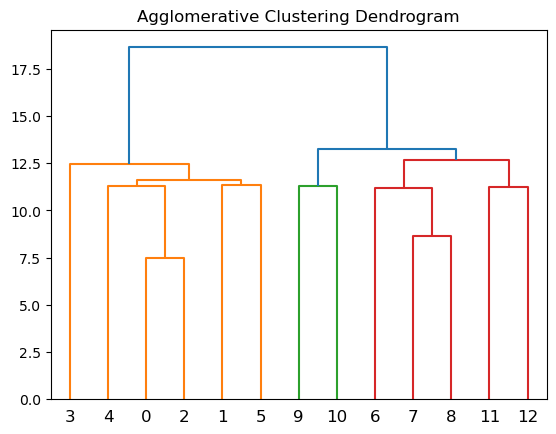

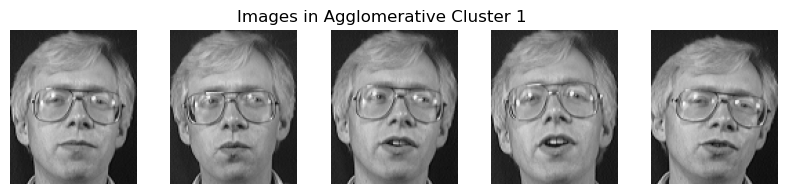

In [20]:
# c) Try agglomerative clustering on some images
# TODO: hint: use linkage command for agglomerative clustering with "single" metric and put the results in "Z_agglo" variable
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

checkImages = list(range(8,21)) # You can use any index, here index 8-20 have been selected

Z_agglo = linkage(imagesTrain.T[checkImages], method='single')

fig = plt.figure()
dn = dendrogram(Z_agglo)

plt.title("Agglomerative Clustering Dendrogram")
plt.show()
num_clusters_agglo = 2  # Change for different grouping

c = fcluster(Z_agglo, t=2, criterion='maxclust') # Chage the value of t to change the number of clusters.

# Visualizing images assigned to Cluster 1
cluster_label = 1  # Change this to visualize other clusters
img_index = np.where(c == cluster_label)[0]

plt.figure(figsize=(10, 2))

# Show the the images that were assigned to cluster 1
img_index = np.where(c == 1)[0] # change this value to see image associated with different clusters.
for i in range(min(len(img_index), 5)):
    plt.figure(111)
    plt.subplot(1, 5, i+1)
    img = np.reshape(imagesTrain[:, checkImages[img_index[i]]], (height, width))
    plt.imshow(img, cmap='gray')
    plt.axis('off')